# EigenFaces Case Study
## Class: MATH373
### Members: Disha Khati and Tyler Soong

In [97]:
# Importing necessary libraries
import pandas as pd
import os
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


In [98]:
# Setting up MediaPipe Face Landmarker (suppress native stderr during setup)
model_path = 'face_landmarker.task'
import os, sys
# Context manager to suppress native (FD-level) stderr from C/C++ extensions
class suppress_native_stderr:
    def __enter__(self):
        sys.stdout.flush(); sys.stderr.flush()
        self._null_fd = os.open(os.devnull, os.O_RDWR)
        self._old_stderr = os.dup(2)
        os.dup2(self._null_fd, 2)
    def __exit__(self, exc_type, exc, tb):
        sys.stdout.flush(); sys.stderr.flush()
        os.dup2(self._old_stderr, 2)
        os.close(self._null_fd)
        os.close(self._old_stderr)
        return False

In [99]:
# Getting the landmarks for the pretty faces
def get_landmarks(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    options = FaceLandmarkerOptions(
        base_options=BaseOptions(model_asset_path=model_path),
        running_mode=VisionRunningMode.IMAGE,
        num_faces=1)
    # Suppressing noisy MediaPipe native logging (FD-level suppression)
    with suppress_native_stderr():
        with FaceLandmarker.create_from_options(options) as landmarker:
            mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=img)
            face_landmarker_result = landmarker.detect(mp_image)

    if not face_landmarker_result.face_landmarks:
        print('meow')
        return None
    # We take the first face detected
    points = []
    for landmark in face_landmarker_result.face_landmarks[0]:
        # Converting normalized to pixel coordinates
        px_x = int(landmark.x * img.shape[1])
        px_y = int(landmark.y * img.shape[0])
        points.append((px_x, px_y))
    return np.array(points, dtype=np.float32)

In [100]:
# Parameters for feature detection and matching
MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.15

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# completely stolen from opn cv
def alignImages(im1, im2):
 
  faces1 = face_cascade.detectMultiScale(im1, 1.3, 5)
  faces2 = face_cascade.detectMultiScale(im2, 1.3, 5)
    
  
  (x, y, w, h) = faces1[0]
  im1 = im1[y:y+h, x:x+w]
  (x, y, w, h) = faces2[0]
  im2 = im2[y:y+h, x:x+w]

  
  points1 = get_landmarks(im1)
  points2 = get_landmarks(im2)

  # Checking if landmarks were actually found
  if points1 is None or points2 is None:
      print("Could not find landmarks in one or both images.")
      return im1, None

  # Calculating the matrix
  # Using indices for eyes/nose: [33, 263, 1]
  h, _ = cv2.estimateAffinePartial2D(points1[[33, 263, 1]], points2[[33, 263, 1]])

  if h is None:
      print("Could not calculate alignment matrix.")
      return im1, None
 

  # Using homography
  height, width, channels = im2.shape
  imgReg = cv2.warpAffine(im1, h, (width, height))
  return imgReg, h


In [101]:
# Loading the images
root_dir = 'usf_headshots'
images = []
for f_name in os.listdir(root_dir):
    img = cv2.imread(os.path.join(root_dir, f_name), cv2.IMREAD_COLOR)

    if img is not None:
        #img = cv2.resize(img, (128, 128)) --- IGNORE ---
        images.append(img)

reference_image = images[2]

In [102]:
# Aligning the images to the reference image and saving them in a new directory
output_dir = 'aligned_headshots'
os.makedirs(output_dir, exist_ok=True)

for i, image in enumerate(images):
    try:
        imgReg, _ = alignImages(image, reference_image)
        outFilename = f"aligned{i}.jpg"
        cv2.imwrite(os.path.join(output_dir, outFilename), imgReg)
    except Exception as e:
        print(f'{i} failed: {e}')

aligned_images = []
for f_name in os.listdir(output_dir):
    img = cv2.imread(os.path.join(output_dir, f_name), cv2.IMREAD_COLOR)
    if img is not None:
        aligned_images.append(img)

np.save('aligned_images.npy', np.array([cv2.cvtColor(cv2.resize(img, (128,128)), cv2.COLOR_BGR2GRAY) for img in aligned_images]))
# Professor Trettel's image failed alignment because the Haar cascade face detector could not find a face in the image :(

3 failed: tuple index out of range


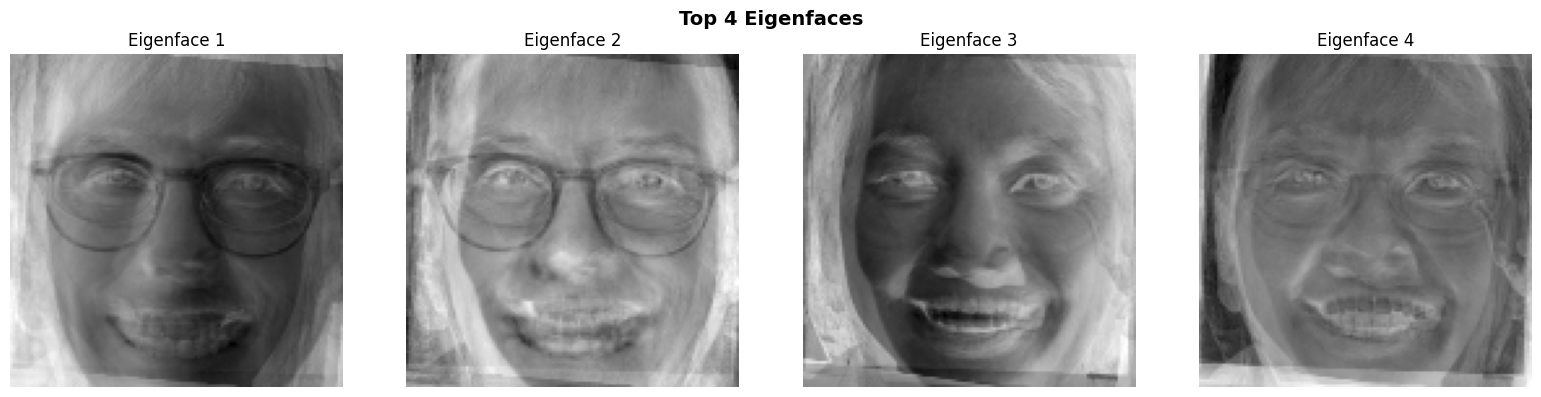

Proportions of variance explained:  [0.24365717 0.19103391 0.15664543 0.06821582]
Total variance explained by the top 4 eigenfaces: 0.65955234
Linear combination coefficients of top 4 Eigenfaces for James: [-382.31848  943.41833   44.81593  397.77704]


In [ ]:
# Getting to the fun part
X = np.load('aligned_images.npy')

# Flattening the images into vectors
flattened = []
for img in X:
    flattened.append(img.flatten())

X = np.array(flattened, dtype=np.float32)

# Getting the "mean" face and centering the data around it
mean_face = np.mean(X, axis=0)
X_centered = X - mean_face

# PCA!!!
pca = PCA()
pca.fit(X_centered)

# Top 4 faces
eigenfaces = pca.components_[:4]  # top 4

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for i, ax in enumerate(axes):
    ef_img = pca.components_[i].reshape(128, 128)
    ef_img = cv2.normalize(ef_img, None, 0, 255, cv2.NORM_MINMAX)
    ax.imshow(ef_img, cmap='gray')
    ax.set_title(f'Eigenface {i+1}')
    ax.axis('off')

plt.suptitle('Top 4 Eigenfaces', fontsize=14, fontweight='bold')
plt.savefig('top_4_eigenfaces.png')
plt.tight_layout()
plt.show()

# Getting proportions of variance explained by the top 4 eigenfaces
variance_explained = pca.explained_variance_ratio_[:4]
print("Proportions of variance explained: ", variance_explained)
print("Total variance explained by the top 4 eigenfaces:", sum(variance_explained))


# Making James the reference image
person = X_centered[14].reshape(1, -1)
coefficients = pca.transform(person)[0][:4]  # weights for top 4 eigenfaces
print("Linear combination coefficients of top 4 Eigenfaces for James:", coefficients)



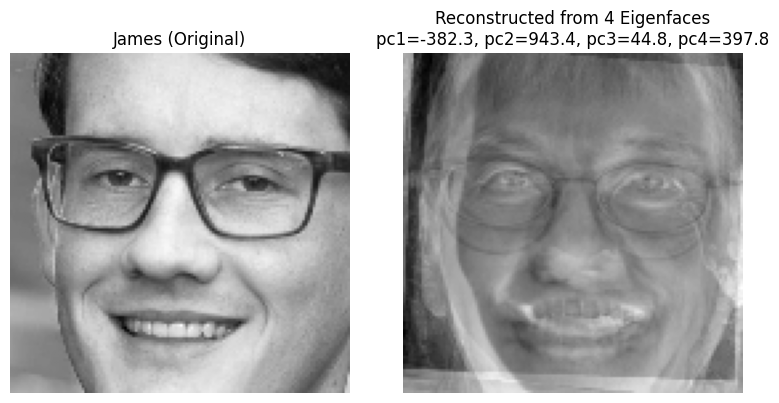

In [ ]:
#Getting a visual of the reconstruction using the top 4 eigenfaces
person_idx = 14

mean_face = pca.mean_
eigenfaces = pca.components_[:4]

# Using pca.transform for correct coefficients
person_centered = X_centered[person_idx].reshape(1, -1)
coefficients = pca.transform(person_centered)[0][:4]

# Reconstructing using these coefficients
reconstructed = mean_face + coefficients @ eigenfaces  

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(X[person_idx].reshape(128, 128), cmap='gray')
axes[0].set_title('James (Original)')
axes[0].axis('off')

axes[1].imshow(reconstructed.reshape(128, 128), cmap='gray')
axes[1].set_title(f'Reconstructed from 4 Eigenfaces\npc1={coefficients[0]:.1f}, pc2={coefficients[1]:.1f}, pc3={coefficients[2]:.1f}, pc4={coefficients[3]:.1f}')
axes[1].axis('off')

plt.tight_layout()
plt.savefig('james_reconstruction.png')
plt.show()